### Agentic RAG
🤖 What is Agentic RAG?

Agentic RAG stands for Agentic Retrieval-Augmented Generation — an advanced version of RAG where instead of a static, one-shot LLM response,the system uses an agent that:

- reasons,
- plans,
- retrieves,
- uses tools,
- and even retries or reflects
to generate better, more grounded answers.

In [15]:
import os
from typing import List, Annotated

from langchain_community.embeddings import HuggingFaceEmbeddings
from pydantic import BaseModel

from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_classic.schema import Document
from langgraph.graph import StateGraph, END

In [16]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm=init_chat_model(model_provider="groq", model="openai/gpt-oss-120b")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x12d2fa990>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x12d2fb4d0>, model_name='openai/gpt-oss-120b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [17]:
# -----------------------------
# 1. Document Preprocessing
# -----------------------------
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/"
]

loaders = [WebBaseLoader(url) for url in urls]
docs = []
for loader in loaders:
    docs.extend(loader.load())

docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [13]:
## Recursive character text splitter an vectorstore
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
split_docs = splitter.split_documents(docs)

embedding = HuggingFaceEmbeddings()
vectorstore = FAISS.from_documents(split_docs, embedding)
retriever = vectorstore.as_retriever()

/var/folders/_m/nv9cbmbs6h38d0yjvxbgmhpj_vx45m/T/ipykernel_39346/3494711946.py:5: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  embedding = HuggingFaceEmbeddings()


In [14]:
retriever.invoke("What are agents")

[Document(id='89a5822b-fabc-4a83-b49b-744e29e58846', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [18]:
# -----------------------------
# 2. Define RAG State
# -----------------------------

class RAGState(BaseModel):
    question: str
    retrieved_docs: List[Document] = []
    answer: str = ""

In [19]:
# -----------------------------
# 3. LangGraph Nodes
# -----------------------------

def retrieve_docs(state: RAGState) -> RAGState:
    docs = retriever.invoke(state.question)
    return RAGState(question=state.question, retrieved_docs=docs)

def generate_answer(state: RAGState) -> RAGState:
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"Answer the question based on the context.\n\nContext:\n{context}\n\nQuestion: {state.question}"
    response = llm.invoke(prompt)
    return RAGState(question=state.question, retrieved_docs=state.retrieved_docs, answer=response.content)

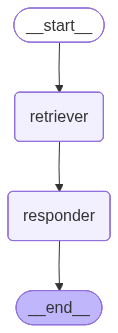

In [20]:
# -----------------------------
# 4. Build LangGraph
# -----------------------------

builder = StateGraph(RAGState)

builder.add_node("retriever", retrieve_docs)
builder.add_node("responder", generate_answer)

builder.set_entry_point("retriever")
builder.add_edge("retriever", "responder")
builder.add_edge("responder", END)

graph = builder.compile()
graph

In [21]:
# -----------------------------
# 5. Run the Agentic RAG
# -----------------------------

if __name__ == "__main__":
    user_question = "What is the concept of agent loop in autonomous agents?"
    initial_state = RAGState(question=user_question)
    final_state = graph.invoke(initial_state)

    print("\n✅ Final Answer:\n", final_state['answer'])


✅ Final Answer:
 **Agent loop (the core cycle of an autonomous LLM‑powered agent)**  

An autonomous agent repeatedly runs a **feedback loop** that ties together perception, reasoning, execution, and learning. The loop can be broken down into the following stages, each of which may be implemented with a large language model (LLM) and auxiliary tools:

| Step | What happens | Why it matters |
|------|--------------|----------------|
| **1. Observe / Retrieve** | The agent gathers information from the environment (e.g., reads a webpage, queries a database, receives user input). | Provides the current state that the model must reason about. |
| **2. Plan / Decompose** | Using the observed state, the agent **breaks the overall goal into sub‑goals** (task decomposition) and selects a concrete next action. | Makes large, complex tasks tractable and guides the next move. |
| **3. Act / Execute** | The chosen action is carried out (e.g., calling an API, writing a file, sending a message). | P

In [22]:
final_state

{'question': 'What is the concept of agent loop in autonomous agents?',
 'retrieved_docs': [Document(id='33d1af5b-d738-4c03-a6ec-696d049eaa65', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism an